Import packages

In [1]:
import pandas as pd
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as EN_STOPWORDS
from tqdm import tqdm
import matplotlib.pyplot as plt

tqdm.pandas()
print("Imports & tqdm ready")


Imports & tqdm ready


Load/Prepare data

(12853, 7)
Index(['Unnamed: 0', 'outlet', 'date', 'year', 'authors', 'title', 'body'], dtype='object')
Nu gaan we de duplicates verwijderen
12853
12837
Data loaded & text combined
                   duplicate_rows  duplicate_groups
outlet                                             
AD Online                      14                 7
NRC Online                      6                 3
Volkskrant Online               6                 3
Telegraaf Print                 3                 1
AD Print                        2                 1
Trouw Print                     0                 0
FD                              0                 0
Trouw Online                    0                 0
FD Print                        0                 0
Telegraaf Online                0                 0
Aantal artikelen per outlet:
outlet
AD Online            3915
Trouw Print          1531
Telegraaf Print      1263
AD Print             1144
Trouw Online         1026
Volkskrant Online    1009
FD  

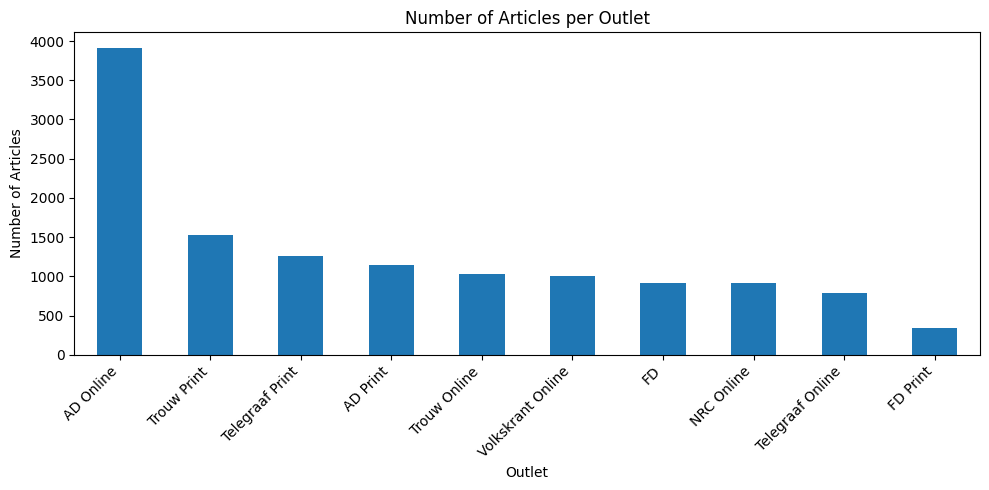

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Dutch_Migration_News.csv")
print(df.shape)
print(df.columns)
df = df.drop(columns=['Unnamed: 0'])
print("Nu gaan we de duplicates verwijderen")
cols = ["outlet", "date", "year", "authors", "title", "body"]
print(len(df))

# duplicates in raw data
dups = df[df.duplicated(subset=cols, keep=False)].copy()

# Duplicate rows per outlet
rows_per_outlet = dups["outlet"].value_counts().rename("duplicate_rows")

# Duplicate groups per outlet (unique duplicated articles)
groups_per_outlet = (
    dups.drop_duplicates(subset=cols)
        .groupby("outlet")
        .size()
        .rename("duplicate_groups")
)

df = df.drop_duplicates(subset=cols, keep="first")
#print(len(duplicates_all))
print(len(df))

TITLE_COL = "title"
BODY_COL  = "body"

df[TITLE_COL] = df[TITLE_COL].astype(str)
df[BODY_COL]  = df[BODY_COL].astype(str)
df = df.drop_duplicates(subset=cols, keep="first")

# clean_text / combined text variable
df["text"] = df[TITLE_COL] + " " + df[BODY_COL]

print("Data loaded & text combined")
df.head(10)

# All outlets (including those with 0 duplicates)
all_outlets = pd.Index(df["outlet"].unique(), name="outlet")

summary_all = (
    pd.DataFrame(index=all_outlets)
      .join(rows_per_outlet, how="left")
      .join(groups_per_outlet, how="left")
      .fillna(0)
      .astype(int)
      .sort_values(["duplicate_groups", "duplicate_rows"], ascending=False)
)

print(summary_all)

cols = ["outlet", "date", "year", "authors", "title", "body"]
df["title"] = df["title"].astype(str)
df["body"]  = df["body"].astype(str)
df["authors"] = df["authors"].astype(str)

df = df.drop_duplicates(subset=cols, keep="first")

# Count articles per outlet
outlet_counts = df["outlet"].value_counts().sort_values(ascending=False)

print("Aantal artikelen per outlet:")
print(outlet_counts)

# Barplot
plt.figure(figsize=(10, 5))
outlet_counts.plot(kind="bar")
plt.title("Number of Articles per Outlet")
plt.xlabel("Outlet")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Load Spacy model (Dutch)

In [3]:

!python -m spacy download nl_core_news_sm
nlp = spacy.load("nl_core_news_sm")
print("SpaCy model loaded")


[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: C:\Users\kevin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------------------------------- ------- 10.5/12.8 MB 72.5 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 50.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('nl_core_news_sm')
SpaCy model loaded


Preprocessing function

In [4]:
def clean_text_spacy(doc):
    # Define which parts of speech to keep.
    # We keep content-bearing words that carry meaning:
    # - NOUN: topics and concepts (e.g. asylum, policy)
    # - PROPN: named entities (e.g. countries, institutions)
    # - ADJ: evaluations and descriptions (e.g. humanitarian, illegal)
    # - VERB: actions and processes (e.g. arrive, restrict)
    include_pos = ["NOUN", "PROPN", "ADJ", "VERB"]

    # Build a cleaned text string by:
    # - iterating over SpaCy tokens in the document
    # - keeping only tokens with the selected POS tags
    # - removing stopwords (function words with little semantic value)
    # - lemmatizing tokens to reduce different word forms to a base form
    text = " ".join(
        t.lemma_.strip()
        for t in doc
        if (
            t.pos_ in include_pos
            and not t.is_stop              # Dutch stopwords
            and t.lemma_.lower() not in EN_STOPWORDS  # English stopwords
        )
    )
    # Remove punctuation to avoid non-informative symbols in the vocabulary
    text = text.translate(str.maketrans(" ", " ", string.punctuation))

    # Remove digits to prevent numbers (years, counts) from dominating topics
    text = text.translate(str.maketrans(" ", " ", string.digits))

    # Convert text to lowercase to ensure consistent token matching
    text = text.lower()

    # Return the cleaned text string, ready for vectorization and topic modeling
    return text

# Simple confirmation that the preprocessing function has been defined
print("Preprocessing function defined")


Preprocessing function defined


NLP + Progress (slowest step)

In [5]:
# Apply the SpaCy NLP pipeline to each document in the dataset.
# This step performs tokenization, part-of-speech tagging, lemmatization,
# and stopword identification for each text.
# tqdm's progress_apply is used to display a progress bar,
# which is useful because SpaCy processing can take a long time on large datasets.
df["text_nlp"] = df["text"].progress_apply(lambda x: nlp(x))

# Print confirmation once all documents have been processed by SpaCy
print("SpaCy NLP completed")



100%|██████████| 12837/12837 [14:26<00:00, 14.81it/s]

SpaCy NLP completed


Clean text & tokens

In [6]:
# Apply the custom preprocessing function to the SpaCy Doc objects.
# This step:
# - filters tokens by part-of-speech (content words only)
# - removes stopwords
# - lemmatizes tokens
# - removes punctuation and digits
# - converts all text to lowercase
# The result is a cleaned text string suitable for vectorization.
df["clean_text"] = df["text_nlp"].apply(clean_text_spacy)

# Create a tokenized version of the cleaned text.
# This splits the cleaned text string into individual tokens (words),
# which can be useful for inspection, debugging, or alternative modeling approaches.
df["clean_tokens"] = df["clean_text"].apply(lambda x: x.split())

# Print confirmation that preprocessing has completed successfully
print("Clean text & tokens created")



Clean text & tokens created


Sanity check

In [7]:
df.head()

,outlet,date,year,authors,title,body,text,text_nlp,clean_text,clean_tokens
0,NRC Online,NaN,2000,Merijn de Waal,‘El Chino’ bracht Peru met harde hand en veel ...,Als kind op het schoolplein wordt de Peruaanse...,‘El Chino’ bracht Peru met harde hand en veel ...,"(‘, El, Chino, ’, bracht, Peru, met, harde, ha...",el chino brengen peru hard hand bloedvergiet s...,"[el, chino, brengen, peru, hard, hand, bloedve..."
1,NRC Online,NaN,2000,Juurd Eijsvoogel,"‘Wij vinden onszelf niet rechts’, zegt vertrek...",Wie verwachtte dat het opinieweekblad EW (voor...,"‘Wij vinden onszelf niet rechts’, zegt vertrek...","(‘, Wij, vinden, onszelf, niet, rechts, ’, ,, ...",vinden rechts zeggen vertrekken hoofdredacteur...,"[vinden, rechts, zeggen, vertrekken, hoofdreda..."
2,NRC Online,NaN,2001,Casper van der Veen,Israël staat toe dat humanitaire hulp wordt ge...,Israël zal humanitaire hulp die vanuit Egypte ...,Israël staat toe dat humanitaire hulp wordt ge...,"(Israël, staat, toe, dat, humanitaire, hulp, w...",israël staan humanitair hulp leveren gazastroo...,"[israël, staan, humanitair, hulp, leveren, gaz..."
3,NRC Online,NaN,2001,Bas Blokker,‘Als Amerikanen zijn we verre van volmaakt’ ‘A...,"‘Mag ik wat Nederlandse exemplaren meenemen”, ...",‘Als Amerikanen zijn we verre van volmaakt’ ‘A...,"(‘, Als, Amerikanen, zijn, we, verre, van, vol...",‘ amerikaan volmaakt ’ ‘ amerikaan volmaakt ’ ...,"[‘, amerikaan, volmaakt, ’, ‘, amerikaan, volm..."
4,AD Print,NaN,2001,ROBIN ROTMAN,INTERVIEW Eric Fuanani moet zijn voetbaldroom ...,ROBIN ROTMAN\nKLUNDERT\nEric Fuanani (17) uit ...,INTERVIEW Eric Fuanani moet zijn voetbaldroom ...,"(INTERVIEW, Eric, Fuanani, moet, zijn, voetbal...",interview eric fuanani voetbaldroom licht opge...,"[interview, eric, fuanani, voetbaldroom, licht..."


Subresearch Question 1

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

NUM_TOPICS = 10
N_TOP_WORDS = 10

# 1) Convert preprocessed text into BoW/counts
# (df["clean_text"] comes from SpaCy preprocessing)
vectorizer = CountVectorizer(
    min_df=20,   # remove very rare terms (tweak if needed)
    max_df=0.5   # remove overly common terms
)

X_counts = vectorizer.fit_transform(df["clean_text"])

# 2) Fit LDA
lda_model = LatentDirichletAllocation(
    n_components=NUM_TOPICS,
    random_state=42
)
doc_topic = lda_model.fit_transform(X_counts)

# 3) Dominant topic per document (SRQ1 output)
df["topic"] = doc_topic.argmax(axis=1)

# 4) Print topics (top words per topic)
feature_names = np.array(vectorizer.get_feature_names_out())

for topic_idx, topic_weights in enumerate(lda_model.components_):
    top_word_idx = topic_weights.argsort()[-N_TOP_WORDS:][::-1]
    top_words = feature_names[top_word_idx]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")


Topic 0: nederland, zaak, rechter, minister, onderzoek, kamer, vinden, nederlands, politie, justitie
Topic 1: gemeente, statushouders, asielzoeker, nederland, aantal, nieuw, verblijfsvergunning, opvang, maand, werk
Topic 2: kind, zitten, goed, vinden, leven, nederland, vrouw, dag, weten, heel
Topic 3: bedrijf, goed, nieuw, euro, stad, nederlands, spelen, zitten, geld, nederland
Topic 4: land, europees, europa, politiek, partij, eu, trump, nieuw, nederland, goed
Topic 5: gemeente, vluchteling, asielzoeker, opvang, coa, azc, burgemeester, plek, bewoner, nieuw
Topic 6: vluchteling, migranten, land, turkije, grens, politie, turks, pagina, man, europa
Topic 7: partij, vvd, kabinet, wilders, politiek, rutte, pvv, cda, israël, kamer
Topic 8: leven, boek, goed, schrijven, verhaal, denken, vinden, wereld, weten, laten
Topic 9: land, oekraïne, oorlog, russisch, vluchteling, rusland, militair, miljoen, oekraïens, syrië


Subresearch question 2

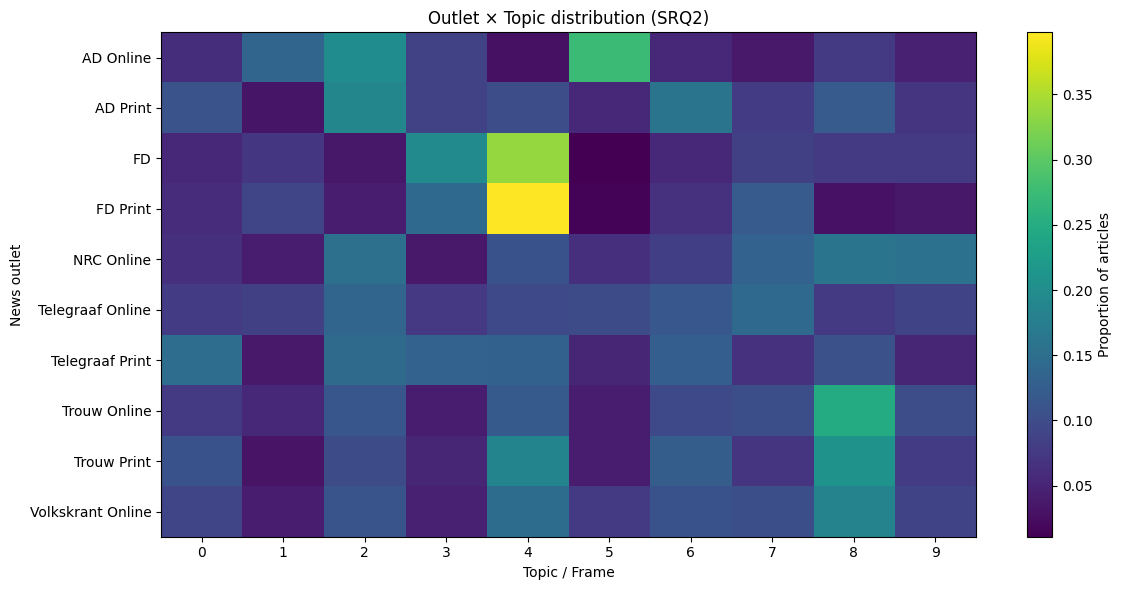

In [9]:

# 1) Outlet × Topic table (counts)
outlet_topic_counts = pd.crosstab(df["outlet"], df["topic"])

# 2) Normalize per outlet (proportions)
outlet_topic_prop = outlet_topic_counts.div(outlet_topic_counts.sum(axis=1), axis=0).fillna(0)

# 3) Heatmap (matplotlib)
plt.figure(figsize=(12, 6))
plt.imshow(outlet_topic_prop.values, aspect="auto")
plt.colorbar(label="Proportion of articles")

plt.title("Outlet × Topic distribution (SRQ2)")
plt.xlabel("Topic / Frame")
plt.ylabel("News outlet")

plt.xticks(range(outlet_topic_prop.shape[1]), outlet_topic_prop.columns)
plt.yticks(range(outlet_topic_prop.shape[0]), outlet_topic_prop.index)

plt.tight_layout()
plt.show()


Subresearch question 3

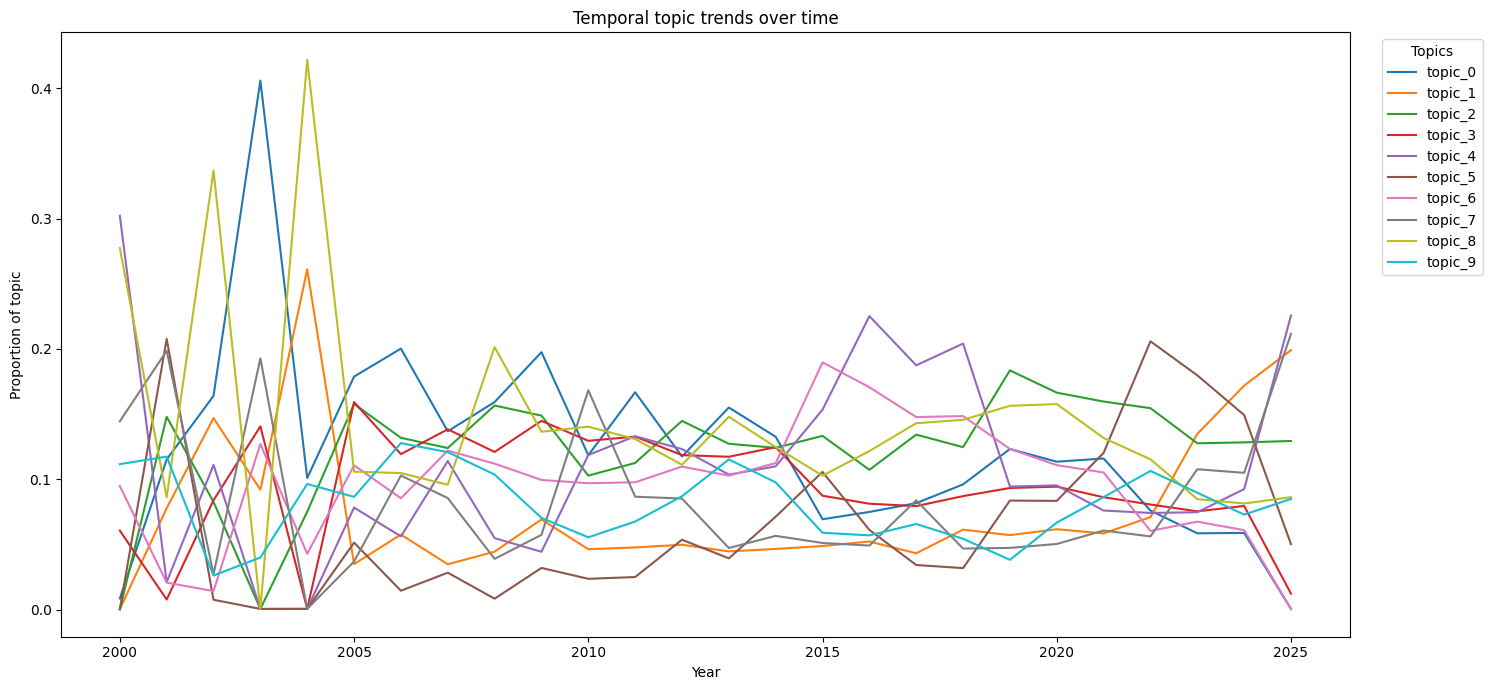

In [14]:
# 1) Topic proportions
topic_cols = [f"topic_{i}" for i in range(NUM_TOPICS)]
df_topics = pd.concat([df.reset_index(drop=True),
    pd.DataFrame(doc_topic, columns=topic_cols)],
    axis=1)

# Calculate topic trends by year
topic_trends = df_topics.groupby('year')[topic_cols].mean()

# 2) Plot temporal topic trends
plt.figure(figsize=(15, 7))

for topic in topic_cols:
    plt.plot(topic_trends.index,
        topic_trends[topic],
        label=topic)

plt.xlabel("Year")
plt.ylabel("Proportion of topic")
plt.title("Temporal topic trends over time")
plt.legend(title="Topics", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [16]:
mean_topic_prevalence = topic_trends.sum()/len(topic_trends)
print("Topics by prevalence")
print(mean_topic_prevalence)
sd_topic = topic_trends.std()
print("Topics by standard deviation")
print(sd_topic)
topic_trends


Topics by prevalence
topic_0    0.124042
topic_1    0.077404
topic_2    0.122487
topic_3    0.094403
topic_4    0.110504
topic_5    0.064168
topic_6    0.097420
topic_7    0.084535
topic_8    0.144133
topic_9    0.080904
dtype: float64
Topics by standard deviation
topic_0    0.076890
topic_1    0.058473
topic_2    0.043438
topic_3    0.041234
topic_4    0.071742
topic_5    0.062116
topic_6    0.045219
topic_7    0.055892
topic_8    0.085014
topic_9    0.027425
dtype: float64


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
year,,,,,,,,,,
2000,0.008513,0.000234,0.000234,0.060599,0.302083,0.000234,0.094771,0.144406,0.277358,0.111568
2001,0.115161,0.077732,0.147885,0.007673,0.021086,0.207704,0.020666,0.198574,0.086143,0.117376
2002,0.163955,0.146944,0.082534,0.083879,0.110981,0.007510,0.014200,0.027152,0.336728,0.026117
2003,0.405880,0.091957,0.000480,0.140549,0.000480,0.000480,0.127030,0.192723,0.000480,0.039942
2004,0.100875,0.261020,0.075020,0.000537,0.000537,0.000537,0.042803,0.000537,0.421796,0.096339
2005,0.178743,0.034918,0.157755,0.159177,0.078244,0.051343,0.110666,0.036883,0.105803,0.086468
2006,0.200203,0.057530,0.131770,0.119245,0.056136,0.014463,0.085383,0.102836,0.104720,0.127714
2007,0.136776,0.034743,0.123920,0.138299,0.113961,0.028288,0.121967,0.085523,0.095751,0.120773
2008,0.159206,0.044409,0.156540,0.120932,0.054797,0.008330,0.111935,0.038906,0.201371,0.103575


Subresearch question 4

Rows used for sentiment: 12837 out of 12837
Using device: cuda
Processed 16/12837 articles
Processed 816/12837 articles
Processed 1616/12837 articles
Processed 2416/12837 articles
Processed 3216/12837 articles
Processed 4016/12837 articles
Processed 4816/12837 articles
Processed 5616/12837 articles
Processed 6416/12837 articles
Processed 7216/12837 articles
Processed 8016/12837 articles
Processed 8816/12837 articles
Processed 9616/12837 articles
Processed 10416/12837 articles
Processed 11216/12837 articles
Processed 12016/12837 articles
Processed 12816/12837 articles

Star rating counts:
sent_stars
1    6325
2    2665
3    2146
4    1319
5     382
Name: count, dtype: int64

Mean sentiment per topic/frame (compound):
           mean  count
topic                 
0     -0.763401   1082
1     -0.724638    966
2     -0.246220   1852
3     -0.423077   1092
4     -0.584665   1565
5     -0.511378   1538
6     -0.713445   1190
7     -0.625379    989
8     -0.227805   1622
9     -0.673220    94

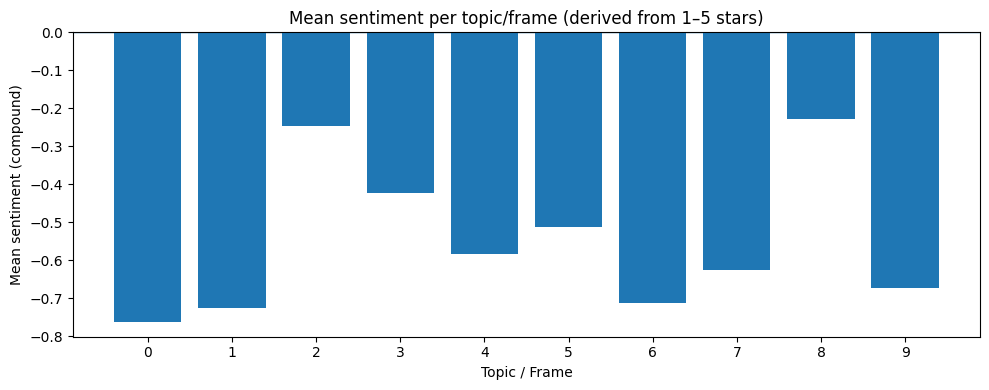

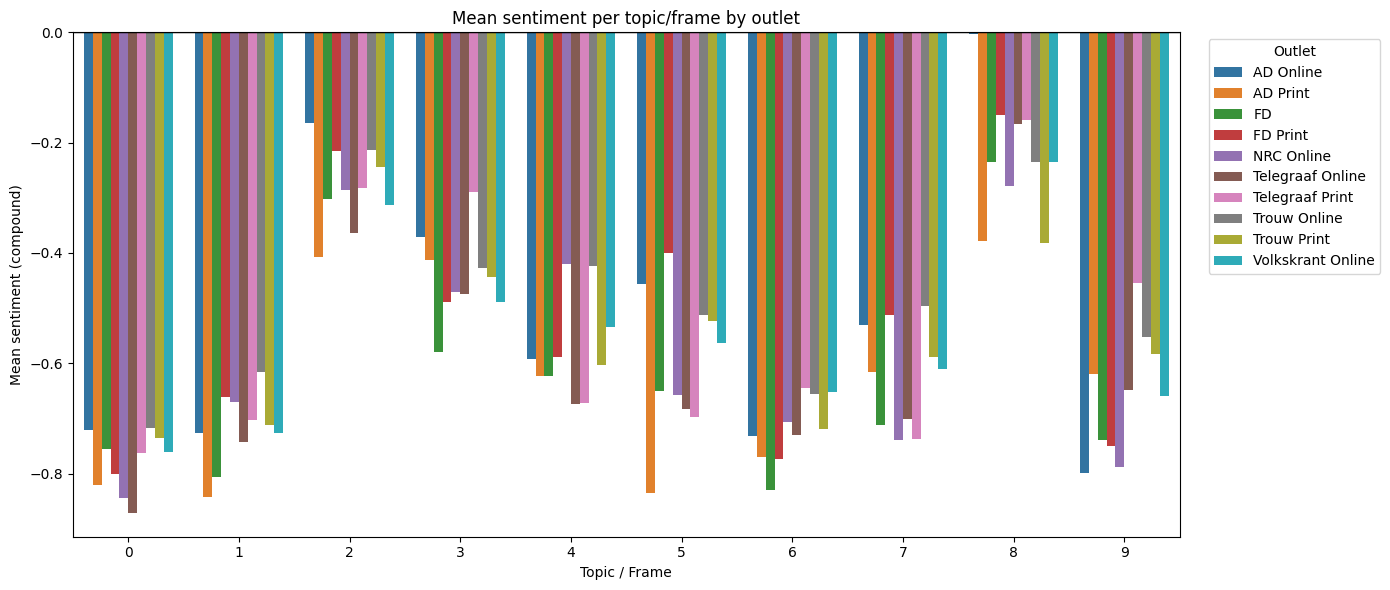

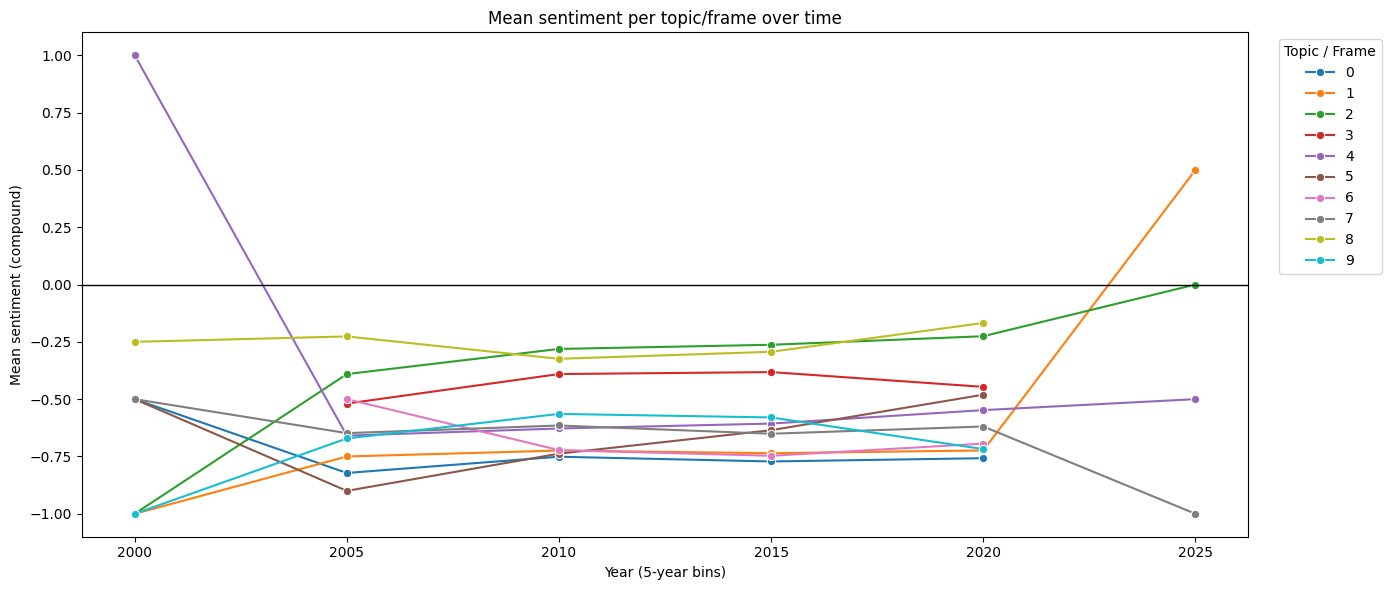

In [18]:
# =========================
# SRQ4: Sentiment per topic/frame
# (keep your pipeline, but replace heatmaps with grouped barplot + lineplot)
# =========================

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Checks
required_cols = {"outlet", "year", "body", "topic"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}. Available columns: {list(df.columns)}")

df_s = df.copy()
df_s["body"] = df_s["body"].fillna("").astype(str)
df_s = df_s[df_s["body"].str.strip().str.len() > 0].copy()
print("Rows used for sentiment:", len(df_s), "out of", len(df))

# 2) Install deps
!{sys.executable} -m pip -q install transformers torch seaborn

import torch
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Robust multilingual model (WordPiece tokenizer, avoids SentencePiece/tiktoken conversion issues)
MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device)
model.eval()

@torch.no_grad()
def predict_stars_and_compound(texts, batch_size=16, max_length=256):
    """
    Model outputs logits for 5 labels: 1 star..5 stars.
    We compute:
      - stars_pred in {1,2,3,4,5}
      - star_probs (N,5)
      - sent_compound = (stars_pred - 3) / 2  -> approx [-1, +1] in steps of 0.5
    """
    stars_pred_list = []
    compound_list = []
    probs_list = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        enc = {k: v.to(device) for k, v in enc.items()}

        logits = model(**enc).logits  # (B, 5)
        probs = torch.softmax(logits, dim=1).cpu().numpy()

        pred_idx = probs.argmax(axis=1)          # 0..4
        stars_pred = pred_idx + 1                # 1..5
        compound = (stars_pred - 3) / 2          # -1..+1 step 0.5

        stars_pred_list.extend(stars_pred.tolist())
        compound_list.extend(compound.tolist())
        probs_list.extend(probs.tolist())

        # lightweight progress print (no widgets)
        if (i // batch_size) % 50 == 0:
            print(f"Processed {min(i+batch_size, len(texts))}/{len(texts)} articles")

    return np.array(stars_pred_list), np.array(compound_list), np.array(probs_list)

# 3) Run sentiment (on BODY)
texts = df_s["body"].tolist()
stars_pred, compound, probs = predict_stars_and_compound(texts, batch_size=16, max_length=256)

df_s["sent_stars"] = stars_pred
df_s["sent_compound"] = compound
df_s["p_1star"] = probs[:, 0]
df_s["p_2star"] = probs[:, 1]
df_s["p_3star"] = probs[:, 2]
df_s["p_4star"] = probs[:, 3]
df_s["p_5star"] = probs[:, 4]

print("\nStar rating counts:")
print(pd.Series(df_s["sent_stars"]).value_counts().sort_index())

# 4) Aggregations that answer SRQ4

# 4a) Sentiment per topic/frame
sent_by_topic = df_s.groupby("topic")["sent_compound"].agg(["mean", "count"]).sort_index()
print("\nMean sentiment per topic/frame (compound):")
print(sent_by_topic)

# 4b) Outlet × topic sentiment (wide)
sent_outlet_topic = (
    df_s.groupby(["outlet", "topic"])["sent_compound"]
       .mean()
       .unstack("topic")
       .sort_index()
)

# 4c) Year × topic sentiment (wide)
sent_year_topic = (
    df_s.groupby(["year", "topic"])["sent_compound"]
       .mean()
       .unstack("topic")
       .sort_index()
)

# 5) Plots

# 5.1 Mean sentiment per topic (keep as bar)
plt.figure(figsize=(10, 4))
plt.bar(sent_by_topic.index.astype(str), sent_by_topic["mean"].values)
plt.axhline(0, linewidth=1)
plt.title("Mean sentiment per topic/frame (derived from 1–5 stars)")
plt.xlabel("Topic / Frame")
plt.ylabel("Mean sentiment (compound)")
plt.tight_layout()
plt.show()

# 5.2 REPLACE heatmap: Outlet × Topic -> Grouped barplot
sent_outlet_topic_long = (
    sent_outlet_topic
    .reset_index()
    .melt(id_vars="outlet", var_name="topic", value_name="mean_sentiment")
    .dropna(subset=["mean_sentiment"])
)

plt.figure(figsize=(14, 6))
sns.barplot(
    data=sent_outlet_topic_long,
    x="topic",
    y="mean_sentiment",
    hue="outlet"
)
plt.axhline(0, linewidth=1, color="black")
plt.title("Mean sentiment per topic/frame by outlet")
plt.xlabel("Topic / Frame")
plt.ylabel("Mean sentiment (compound)")
plt.legend(title="Outlet", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# 5.3 REPLACE heatmap: Year × Topic -> Line plot (with 5-year bins)
df_s_plot = df_s[["year", "topic", "sent_compound"]].dropna().copy()
df_s_plot["year"] = pd.to_numeric(df_s_plot["year"], errors="coerce")
df_s_plot = df_s_plot.dropna(subset=["year"])
df_s_plot["year"] = df_s_plot["year"].astype(int)

df_s_plot["year_bin"] = (df_s_plot["year"] // 5) * 5

sent_year_topic_long = (
    df_s_plot
    .groupby(["year_bin", "topic"])["sent_compound"]
    .mean()
    .reset_index(name="mean_sentiment")
    .sort_values(["year_bin", "topic"])
)

plt.figure(figsize=(14, 6))

sns.lineplot(
    data=sent_year_topic_long,
    x="year_bin",
    y="mean_sentiment",
    hue="topic",
    marker="o",
    palette="tab10"   # <-- duidelijke, verschillende kleuren
)

plt.axhline(0, linewidth=1, color="black")
plt.title("Mean sentiment per topic/frame over time")
plt.xlabel("Year (5-year bins)")
plt.ylabel("Mean sentiment (compound)")
plt.legend(title="Topic / Frame", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()
